<a href="https://colab.research.google.com/github/stanislavkrk/clustering_and_classification/blob/main/neuralnetwork_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

from keras._tf_keras.keras import Sequential
from keras._tf_keras.keras.layers import Dense, Input, Dropout, BatchNormalization
from keras._tf_keras.keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras import regularizers

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np

import random
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

### Global random fix

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Project Overview
---
## Customer Segmentation & Classification using Neural Networks

In the previous stage of this project, we performed customer segmentation using clustering techniques on transactional and demographic data. As a result, we identified **three different customer profiles**:

### 🟡 **Cluster 0 – Low-Income Passive Shoppers**
- **Purchasing Behavior**: Lowest spending across all product categories, especially wines, meat, and fish.
- **Income**: Lowest average income (~33,000).
- **Marketing Response**: Minimal engagement with campaigns; almost no reactions.
- **Demographics**: Slightly younger average age (~53), typically have 1+ children.
- **Education & Status**: Higher share of basic education; more single or divorced individuals.
- **Customer Insight**: This group is financially constrained and disengaged from marketing. Not the ideal target for premium or campaign-driven strategies.


### 🟢 **Cluster 1 – High-Income Engaged Buyers**
- **Purchasing Behavior**: Highest expenditure, especially on **Wines (~550)** and **Meat (~390)**.
- **Income**: Highest among all clusters (~73,000).
- **Marketing Response**: Most responsive segment; highest campaign acceptance rate.
- **Shopping Activity**: Very active across all channels (store, web, catalog).
- **Demographics**: Lowest number of children (~0.3), highly educated, mostly married.
- **Customer Insight**: Ideal premium customers. They are highly engaged, loyal, and responsive to promotions. Great candidates for exclusive deals and upselling strategies.


### 🟣 **Cluster 2 – Family-Oriented Mid-Spenders**
- **Purchasing Behavior**: Moderate spending, second highest after Cluster 1.
- **Income**: Middle-income bracket (~55,000).
- **Marketing Response**: Average engagement, more than Cluster 0 but less than Cluster 1.
- **Demographics**: Highest number of children (~1.3), oldest average age (58), highly educated.
- **Customer Insight**: Balanced and stable customers. They may respond well to family-oriented offers, value packages, or targeted communication emphasizing practicality and trust.

## Project Goal
---
### Predicting Customer Cluster via Neural Networks

In this phase, we will build a **neural network model** capable of **classifying new customers into one of the three clusters** based on their demographic characteristics and early purchasing behavior.

### Key Idea:
- For existing customers, we have aggregated purchase data over the last two years.
- For new customers, we will simulate a "trial period" (e.g., the first 30 days of activity) to collect initial spending patterns.
- The model will predict which customer segment (cluster) the new client most likely belongs to, using these early indicators.

### Why is this useful?
- Allows the business to apply **personalized marketing strategies** immediately after customer onboarding.
- Helps in **forecasting lifetime value** and **targeting offers** aligned with customer preferences.

### Approach
1. Prepare input features reflecting normalized daily purchasing patterns.
2. Design and train several neural network architectures using the TensorFlow Sequential.
3. Compare models and select the most effective structure.
4. Evaluate model performance on unseen data.


# Data Preparation Logic
---

In this project, we are working with the same dataset that was used for customer segmentation and clustering. Based on this data, we previously identified three customer profiles (clusters) reflecting different purchasing behaviors and demographic characteristics.

To build a neural network classifier for new customer identification, we must ensure that the input features represent **comparable scales of customer activity**.

### Feature Types and Normalization

#### Features aggregated over **2 years (730 days)**:
These features represent total spending over the past two years and need to be normalized to reflect **daily spending intensity**:
- `MntWines`: Amount spent on wine.
- `MntFruits`: Amount spent on fruits.
- `MntMeatProducts`: Amount spent on meat.
- `MntFishProducts`: Amount spent on fish.
- `MntSweetProducts`: Amount spent on sweets.
- `MntGoldProds`: Amount spent on gold.

These will be divided by **730** to calculate an **average daily spending**.

#### Features aggregated over **1 month (30 days)**:
These features represent monthly activity and should be normalized to **daily behavioral frequency**:
- `NumWebPurchases`: Number of purchases through the website.
- `NumCatalogPurchases`: Number of catalog purchases.
- `NumStorePurchases`: Number of in-store purchases.
- `NumDealsPurchases`: Number of purchases using discounts.
- `NumWebVisitsMonth`: Number of website visits in the last month.

These will be divided by **30** to calculate an **average daily activity rate**.

> Even though the dataset does not explicitly specify the period for `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, and `NumDealsPurchases`, their scale and similarity to `NumWebVisitsMonth` (which is explicitly per month) indicate they are also monthly aggregates.

### Why Normalize to Daily Values?

For historical customers, we have long-term cumulative data. For new customers, we will only have data for a **shorter observation period** (e.g., 30 days).

To make fair predictions, we will:
- Normalize historical customer data to daily averages.
- For a new customer: calculate `daily_value = total_value_in_30_days / 30`.

This creates a **consistent daily activity profile**, enabling direct comparison between historical and new customers, regardless of time in the system.

### Model Training & New Customer Classification Workflow

The neural network classifier will be trained on:
- **Demographic features** (income, family status, education, etc.).
- **Behavioral features normalized to daily values**.

When a new customer joins:
1. We will collect their purchasing activity over a **defined window (e.g., 30 days)**.
2. Normalize these cumulative values to daily averages.
3. Feed these features into the trained classifier.
4. The model will predict the customer’s cluster (profile).

### Conclusion

Normalizing all cumulative features to daily values ensures that model predictions are based on **behavioral intensity**, not the absolute time span of customer activity. This makes classification robust, scalable, and relevant for real-time business applications.


### Load already prepared and ready for use dataset

In [ ]:
data = pd.read_csv("https://drive.google.com/uc?export=download&id=1TSpj4gfFZ_BiOKuk0sYNdTHw_mqWeBvl", sep=';')
data.head()

,Income,Recency,Age,Total_Children,Complain,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,...,MntFruits,MntFishProducts,MntSweetProducts,MntGoldProds,NumCatalogPurchases,NumDealsPurchases,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Cluster_index
0,0.428623,0.310532,0.986443,-1.264803,0,0,1,0,0,0,...,1.575685,2.486338,1.513478,0.866616,2.665107,0.393210,1.489127,-0.562736,0.746165,1
1,-0.019686,-0.380509,1.236801,1.405806,0,0,1,0,0,0,...,-0.642898,-0.655466,-0.640293,-0.740103,-0.594517,-0.166264,-1.160791,-1.182374,-0.125705,0
2,0.840808,-0.795134,0.318822,-1.264803,0,0,1,0,0,0,...,0.581148,1.358985,-0.145173,-0.034714,-0.232336,-0.725739,1.489127,1.296179,-0.561640,1
3,-1.114019,-0.795134,-1.266777,0.070501,0,0,1,0,0,0,...,-0.566395,-0.507617,-0.590781,-0.759697,-0.956697,-0.166264,-0.782232,-0.562736,0.310230,0
4,0.433888,1.554407,-1.016420,0.070501,0,0,0,0,1,1,...,0.428142,0.157707,0.003363,-0.563756,0.129844,1.512159,0.353448,0.056903,-0.125705,2


## Neural Network Training Strategy
---

In this project, we follow a structured and practical approach to neural network training and hyperparameter tuning, aligned with real-world industrial practices.

### 1. Architecture Search (Core Model Capacity)

The first and most critical step is defining the model's **architecture**:
- Number of layers (depth)
- Number of neurons per layer (width)
- Activation functions (ReLU, Tanh, etc.)

This step defines the **capacity** of the model — whether it can learn the patterns from data at all.

### 2. Optimizer & Learning Rate Tuning (Learning Behavior)

Once the architecture is fixed, we tune the **learning behavior**:
- Choice of optimizer (SGD, Adam, Nadam, RMSprop, etc.)
- Learning rate adjustment

The optimizer defines how efficiently the model adjusts weights during training. The learning rate, in particular, has a significant impact on convergence and final performance. This step ensures that the model learns in a stable and effective manner.

### 3. Regularization Tuning (Overfitting Control)

After establishing a strong baseline, we introduce **regularization methods** to control overfitting:
- Dropout layers with different rates
- L2 weight regularization (Ridge)

These techniques help the model generalize better to unseen data by preventing memorization of training samples.

### 4. Batch Size & Epochs (Efficiency Tuning)

Finally, we fine-tune **batch size** and **number of epochs**:
- Batch size affects training efficiency and gradient stability.
- Epochs define how long the model is trained.

This step optimizes resource consumption and ensures the model is trained sufficiently without overtraining.


## Making training features

In [ ]:
X_train = data.drop(columns=['Cluster_index'])
y_train = data['Cluster_index']

## Universal model function and wrapper

**Main function**

In [ ]:
def create_model(config: dict, input_dim: int):
    """
    Universal model creator that uses only explicitly provided parameters.
    Adds regularization and dropout only when present in config.
    Uses default optimizer (Adam) and lr if not specified.
    """

    # 1. Necessary parameters
    layers = config.get('layers')
    activation = config.get('activation')

    # 2. If no for first stage, use default
    optimizer_name = config.get('optimizer', 'adam')
    learning_rate = config.get('lr', 0.001)

    opt_map = {'adam': Adam, 'sgd': SGD, 'rmsprop': RMSprop}
    optimizer_class = opt_map.get(optimizer_name, Adam)
    optimizer = optimizer_class(learning_rate=learning_rate)

    # 3. Regularization is optional
    kernel_reg = None
    if 'l2' in config and config['l2'] > 0:
        kernel_reg = regularizers.l2(config['l2'])

    dropout_rate = config.get('dropout_rate', None)

    # 4. Building the model
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    # First layer
    model.add(Dense(layers[0], activation=activation, kernel_regularizer=kernel_reg))
    if dropout_rate is not None and dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Other layers
    for units in layers[1:]:
        model.add(Dense(units, activation=activation, kernel_regularizer=kernel_reg))
        if dropout_rate is not None and dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Out layer
    model.add(Dense(3, activation='softmax'))

    # Compile
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


**Training wrapper**

In [ ]:

def evaluate_model_cv(X, y, config_grid, create_model_fn, k_folds=5):
    """
    Evaluation function for Keras models using K-Fold CV.
    Adds F1-score (macro) alongside val_accuracy.
    All training parameters (epochs, batch_size, etc.) must be inside each config.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for config in config_grid:
        fold_accuracies = []
        fold_f1_scores = []

        epochs = config.get('epochs', 30)
        batch_size = config.get('batch_size', 32)

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = create_model_fn(config)
            model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate accuracy
            _, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            fold_accuracies.append(val_accuracy)

            # Predict and compute F1
            y_pred_probs = model.predict(X_val, verbose=0)
            y_pred = np.argmax(y_pred_probs, axis=1)
            f1 = f1_score(y_val, y_pred, average='macro')
            fold_f1_scores.append(f1)

        results.append({
            'config': config,
            'val_accuracy': np.mean(fold_accuracies),
            'f1_macro': np.mean(fold_f1_scores)
        })

    return pd.DataFrame(results).sort_values(by=['val_accuracy', 'f1_macro'], ascending=False)

## 1. Architecture Search
---

**Model initialization**

In [ ]:
def create_model_architecture(config):
    return create_model(config, input_dim=X_train.shape[1])

**Grid**

In [ ]:
layer_configs = [
    [128],
    [128, 64],
    [128, 64, 32],
    [128, 64, 32, 16]
]
activations = ['relu', 'tanh', 'elu']
fixed_epochs = 30
fixed_batch_size = 32

architecture_grid = [
    {   'epochs': fixed_epochs,
        'batch_size': fixed_batch_size,

        'layers': layers,
        'activation': act,

    }
    for act in activations
    for layers in layer_configs
]


**Starting pipeline**

In [ ]:
results = evaluate_model_cv(
    X=X_train,
    y=y_train,
    config_grid=architecture_grid,
    create_model_fn=create_model_architecture,
    k_folds=5
)

**Results**

In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=['val_accuracy', 'f1_macro'], ascending=False)

df_results[['config', 'val_accuracy', 'f1_macro']]

,config,val_accuracy,f1_macro
0,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.969315,0.968000
11,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.964801,0.963240
1,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.963901,0.962045
9,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.963895,0.962436
4,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.963446,0.961995
3,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.962999,0.961008
8,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.962544,0.960968
2,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.962544,0.960752
5,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.962094,0.960441
10,"{'epochs': 30, 'batch_size': 32, 'layers': [12...",0.961191,0.959449


In [ ]:
best_architecture = df_results.iloc[0]['config']
print("Best architecture:", best_architecture)

Best architecture: {'epochs': 30, 'batch_size': 32, 'layers': [128], 'activation': 'relu'}


**Analysis**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_architecture_heatmaps(df_results, param01='layers', param02='activation'):
    """
    Combined heatmap plot for val_accuracy and f1_macro, grouped by param01 × param02.
    """

    df_expanded = df_results.copy()
    df_expanded[param01] = df_expanded['config'].apply(lambda x: str(x[param01]))
    df_expanded[param02] = df_expanded['config'].apply(lambda x: x[param02])

    # Accuracy
    df_acc = df_expanded.groupby([param01, param02])['val_accuracy'].mean().reset_index()
    df_acc_pivot = df_acc.pivot(index=param01, columns=param02, values='val_accuracy')

    # F1
    df_f1 = df_expanded.groupby([param01, param02])['f1_macro'].mean().reset_index()
    df_f1_pivot = df_f1.pivot(index=param01, columns=param02, values='f1_macro')

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(df_acc_pivot, annot=True, fmt=".4f", cmap="Greens", ax=axes[0])
    axes[0].set_title("Validation Accuracy")
    axes[0].set_ylabel(param01)
    axes[0].set_xlabel(param02)

    sns.heatmap(df_f1_pivot, annot=True, fmt=".4f", cmap="Greens", ax=axes[1])
    axes[1].set_title("Macro F1-score")
    axes[1].set_ylabel(param01)
    axes[1].set_xlabel(param02)

    plt.tight_layout()
    plt.show()


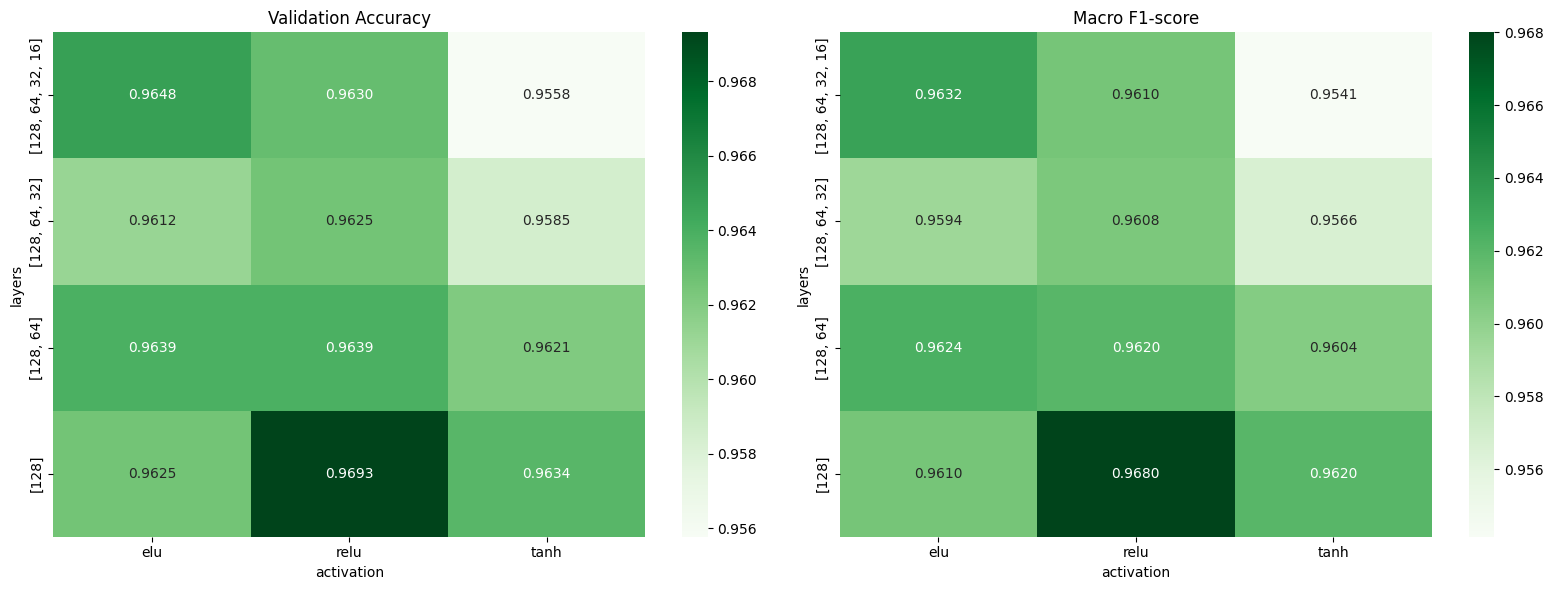

In [ ]:
plot_architecture_heatmaps(df_results, param01='layers', param02='activation')

## 2. Optimizer & Learning Rate Tuning
---

**Model initialization**

In [ ]:
def create_model_optimizer(config):
    return create_model(config=config, input_dim=X_train.shape[1])

**Grid**

In [ ]:
learning_rates = [0.01, 0.005, 0.001, 0.0005]
optimizers = ['adam', 'sgd', 'rmsprop']

layers = best_architecture['layers']
activation = best_architecture['activation']
epochs = 30
batch_size = 32

optimizer_grid = [
    {   'layers': layers,
        'activation': activation,
        'epochs': epochs,
        'batch_size': batch_size,

        'optimizer': opt,
        'lr': lr,
    }
    for opt in optimizers
    for lr in learning_rates
]

**Starting pipeline**

In [ ]:
df_optim_results = evaluate_model_cv(
    X=X_train,
    y=y_train,
    config_grid=optimizer_grid,
    create_model_fn=create_model_optimizer,
    k_folds=5
)

**Results**

In [ ]:
df_optim_results = df_optim_results.sort_values(by=['val_accuracy', 'f1_macro'], ascending=False)

df_optim_results[['config', 'val_accuracy', 'f1_macro']]

,config,val_accuracy,f1_macro
2,"{'layers': [128], 'activation': 'relu', 'epoch...",0.969768,0.968357
3,"{'layers': [128], 'activation': 'relu', 'epoch...",0.965707,0.964195
0,"{'layers': [128], 'activation': 'relu', 'epoch...",0.964798,0.962884
9,"{'layers': [128], 'activation': 'relu', 'epoch...",0.964353,0.962674
11,"{'layers': [128], 'activation': 'relu', 'epoch...",0.963899,0.962436
10,"{'layers': [128], 'activation': 'relu', 'epoch...",0.963449,0.961768
1,"{'layers': [128], 'activation': 'relu', 'epoch...",0.960741,0.958946
8,"{'layers': [128], 'activation': 'relu', 'epoch...",0.958486,0.956428
4,"{'layers': [128], 'activation': 'relu', 'epoch...",0.951265,0.949203
5,"{'layers': [128], 'activation': 'relu', 'epoch...",0.941341,0.938689


In [ ]:
best_optimizer_config = df_optim_results.iloc[0]['config']
print("Best optimizer config:", best_optimizer_config)

Best optimizer config: {'layers': [128], 'activation': 'relu', 'epochs': 30, 'batch_size': 32, 'optimizer': 'adam', 'lr': 0.001}


**Analysis**

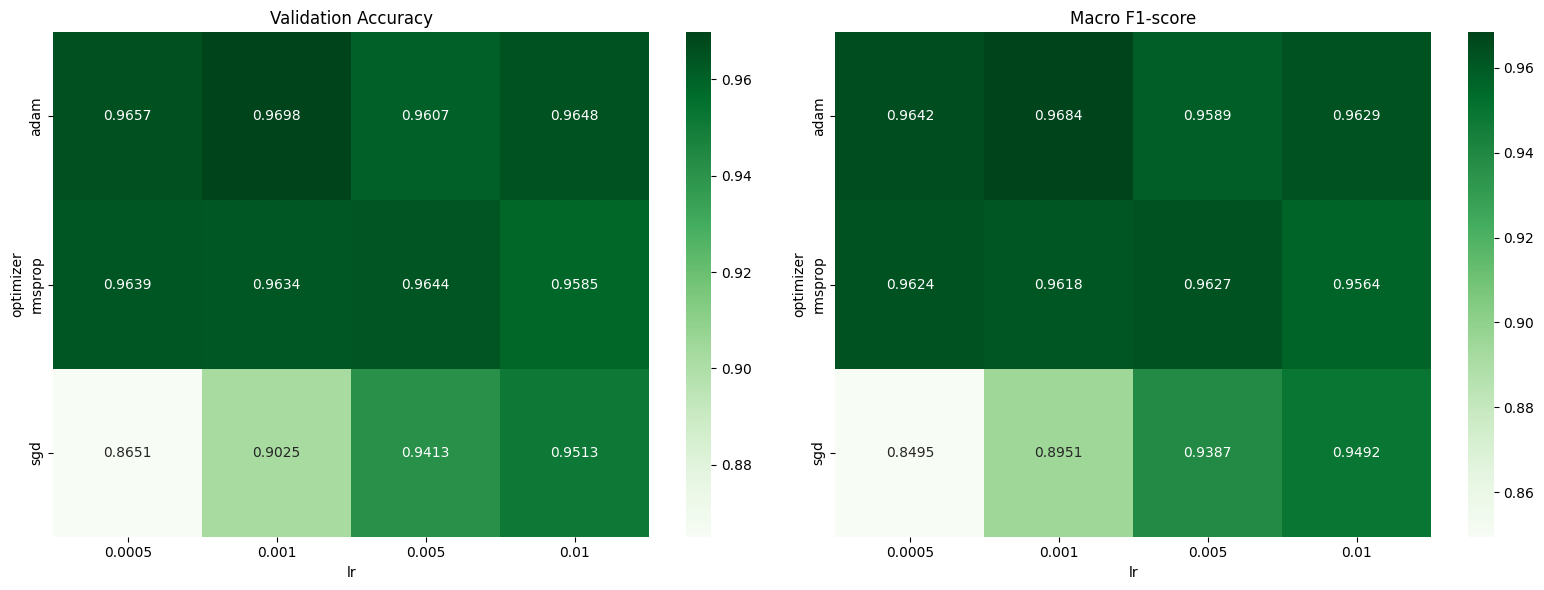

In [ ]:
plot_architecture_heatmaps(df_optim_results, param01='optimizer', param02='lr')

## 3. Regularization Tuning (Overfitting Control)
---

**Model initialization**

In [ ]:
def create_model_regularized(config):
    return create_model(config=config, input_dim=X_train.shape[1])

**Grid**

In [ ]:
dropout_rates = [0.0, 0.3, 0.5]
l2_values = [0.0, 0.001, 0.01]

epochs = 30
batch_size = 32
layers = best_architecture['layers']
activation = best_architecture['activation']
optimizer = best_optimizer_config['optimizer']
lr = best_optimizer_config['lr']

regularization_grid = [
    {
        'layers': layers,
        'activation': activation,
        'optimizer': optimizer,
        'lr': lr,
        'epochs': epochs,
        'batch_size': batch_size,

        'dropout_rate': d,
        'l2': l2,
    }
    for d in dropout_rates
    for l2 in l2_values
]

**Starting training**

In [ ]:
df_reg_results = evaluate_model_cv(
    X=X_train,
    y=y_train,
    config_grid=regularization_grid,
    create_model_fn=create_model_regularized,
    k_folds=5
)

**Results**

In [ ]:
df_reg_results = df_reg_results.sort_values(by=['val_accuracy', 'f1_macro'], ascending=False)

df_reg_results[['config', 'val_accuracy', 'f1_macro']]

,config,val_accuracy,f1_macro
1,"{'layers': [128], 'activation': 'relu', 'optim...",0.969767,0.968564
0,"{'layers': [128], 'activation': 'relu', 'optim...",0.967512,0.966080
4,"{'layers': [128], 'activation': 'relu', 'optim...",0.967059,0.965672
3,"{'layers': [128], 'activation': 'relu', 'optim...",0.967059,0.965583
6,"{'layers': [128], 'activation': 'relu', 'optim...",0.966608,0.965112
7,"{'layers': [128], 'activation': 'relu', 'optim...",0.965706,0.964092
8,"{'layers': [128], 'activation': 'relu', 'optim...",0.964353,0.962769
2,"{'layers': [128], 'activation': 'relu', 'optim...",0.961192,0.959498
5,"{'layers': [128], 'activation': 'relu', 'optim...",0.959841,0.957951


In [ ]:
best_regularization_config = df_reg_results.sort_values(by='val_accuracy', ascending=False).iloc[0]['config']
print("Best regularization config:", best_regularization_config)

Best regularization config: {'layers': [128], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001, 'epochs': 30, 'batch_size': 32, 'dropout_rate': 0.0, 'l2': 0.001}


**Analysis**

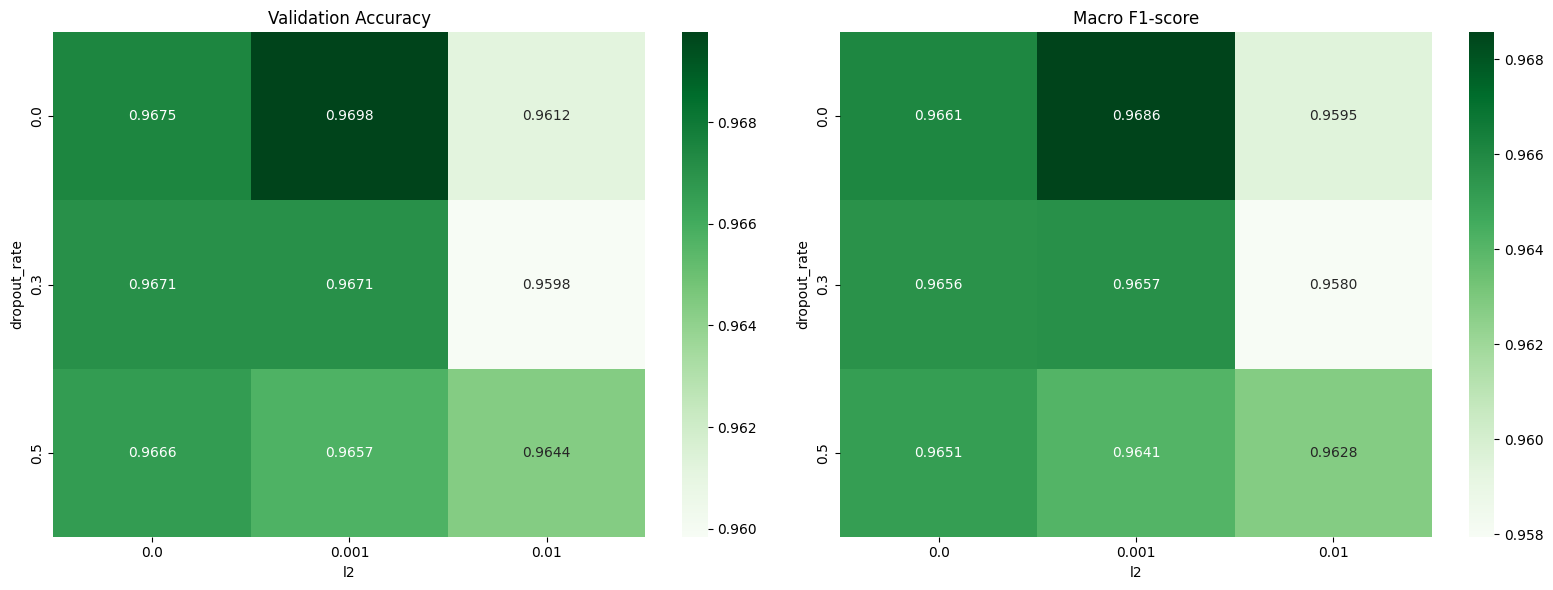

In [ ]:
plot_architecture_heatmaps(df_reg_results, param01='dropout_rate', param02='l2')

## 4. Batch Size & Epochs (Efficiency Tuning)
---


**Model initialization**

In [ ]:
def create_model_batch_epoch(config):
    return create_model(config=config, input_dim=X_train.shape[1])


**Grid**

In [ ]:
batch_sizes = [16, 32, 64]
epochs_list = [20, 30, 50]

layers = best_architecture['layers']
activation = best_architecture['activation']
optimizer = best_optimizer_config['optimizer']
lr = best_optimizer_config['lr']
l2 = best_regularization_config['l2']
dropout_rate = best_regularization_config['dropout_rate']

batch_epoch_grid = [
    {
        'layers': layers,
        'activation': activation,
        'optimizer': optimizer,
        'lr': lr,
        'l2': l2,
        'dropout_rate': dropout_rate,

        'batch_size': bs,
        'epochs': ep
    }
    for bs in batch_sizes
    for ep in epochs_list
]

**Starting pipeline**

In [ ]:
df_batch_epoch = evaluate_model_cv(
    X=X_train,
    y=y_train,
    config_grid=batch_epoch_grid,
    create_model_fn=create_model_batch_epoch,
    k_folds=5
)

**Results**

In [ ]:
df_batch_epoch = df_batch_epoch.sort_values(by=['val_accuracy', 'f1_macro'], ascending=False)
df_batch_epoch[['config', 'val_accuracy', 'f1_macro']]

,config,val_accuracy,f1_macro
5,"{'layers': [128], 'activation': 'relu', 'optim...",0.969766,0.968510
8,"{'layers': [128], 'activation': 'relu', 'optim...",0.968414,0.967094
4,"{'layers': [128], 'activation': 'relu', 'optim...",0.967963,0.966582
7,"{'layers': [128], 'activation': 'relu', 'optim...",0.966610,0.965088
1,"{'layers': [128], 'activation': 'relu', 'optim...",0.966157,0.964615
2,"{'layers': [128], 'activation': 'relu', 'optim...",0.965254,0.963548
3,"{'layers': [128], 'activation': 'relu', 'optim...",0.964804,0.963257
0,"{'layers': [128], 'activation': 'relu', 'optim...",0.964352,0.962747
6,"{'layers': [128], 'activation': 'relu', 'optim...",0.962548,0.960918


In [ ]:
best_batch_epoch_config = df_batch_epoch.iloc[0]['config']
print("Best batch and epochs config:", best_batch_epoch_config)

Best batch and epochs config: {'layers': [128], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001, 'l2': 0.001, 'dropout_rate': 0.0, 'batch_size': 32, 'epochs': 50}


**Analysis**

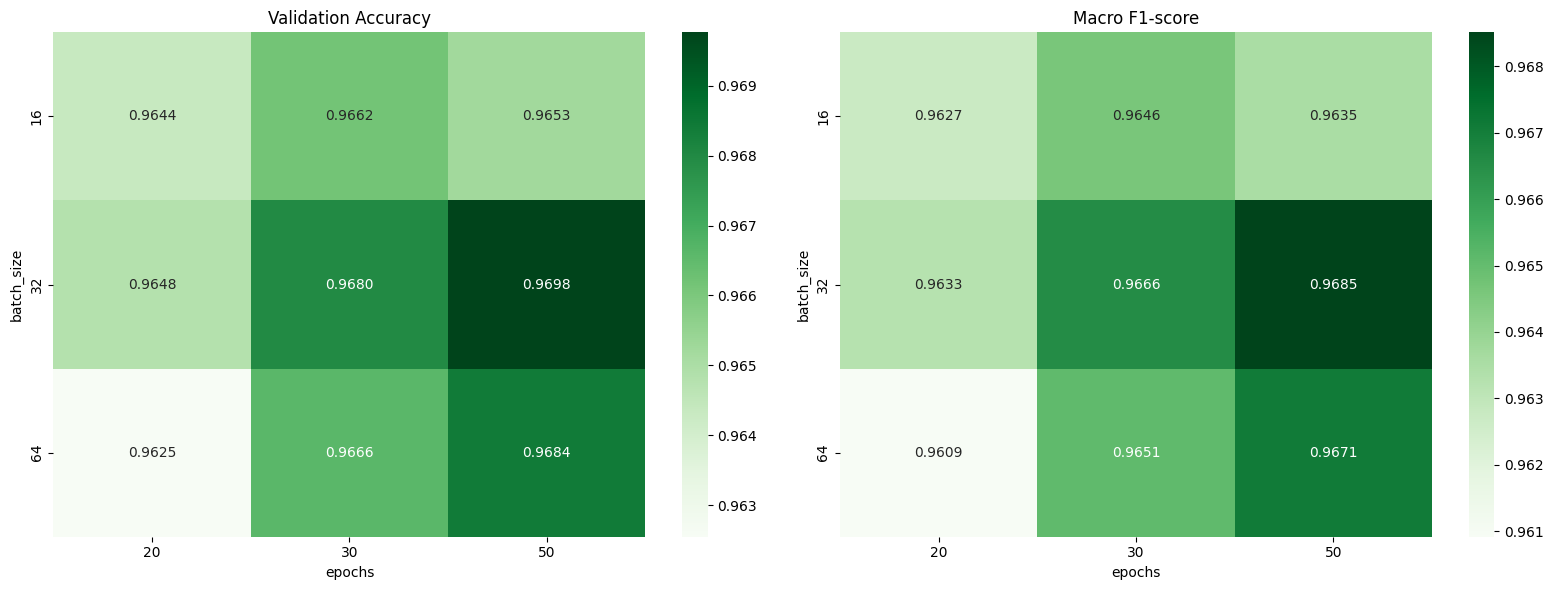

In [ ]:
plot_architecture_heatmaps(df_batch_epoch, param01='batch_size', param02='epochs')

# Best config
---
### Merge from all best-dictionaries total config-dictionary for top-model

In [ ]:
best_model_config = {
    **best_architecture,
    **best_optimizer_config,
    **best_regularization_config,
    **best_batch_epoch_config
}

In [ ]:
best_model_config

{'epochs': 50,
 'batch_size': 32,
 'layers': [128],
 'activation': 'relu',
 'optimizer': 'adam',
 'lr': 0.001,
 'dropout_rate': 0.0,
 'l2': 0.001}

## Final Model Summary
---
**Neural Network Classifier for Customer Segmentation**

This report summarizes the outcome of a structured, multi-stage hyperparameter optimization process used to build the best-performing feedforward neural network model for classifying customer profiles. Each stage of the pipeline targeted a specific group of hyperparameters to evaluate their impact on validation performance using K-Fold cross-validation. The final model was selected based on the highest average validation accuracy and F1-Score.


### 1. Architecture Search

**Tested Configurations:**
- Depth: 1 to 4 hidden layers
- Units: fixed [128, 64, 32, 16] patterns
- Activation functions: `relu`, `tanh`, `elu`

**Result:**
- The best-performing architecture had only **one hidden layer with 128 neurons** and used the **ReLU activation** function.

**Analysis:**
Deeper architectures did not improve performance and in some cases degraded it. The shallow network generalizes better to this specific dataset, likely due to its relatively simple decision boundaries. The **ReLU** activation outperformed **tanh** and **elu**, suggesting that vanishing gradient issues were minimal and the linear rectifier allowed efficient optimization.


### 2. Optimizer and Learning Rate Tuning

**Tested Optimizers:**
- `adam`, `sgd`, `rmsprop`
- Learning rates: 0.01, 0.005, 0.001, 0.0005

**Result:**
- Best: **Adam optimizer with learning rate = 0.001**

**Analysis:**
**Adam** delivered more stable and higher validation performance than **SGD** and **RMSprop**. The **learning rate** of 0.001 emerged as the sweet spot, avoiding instability (as seen with 0.01) while allowing reasonably fast convergence. SGD showed notably worse results, confirming its sensitivity to learning rate and lack of adaptive scaling in comparison to Adam.

### 3. Regularization Tuning

**Tested:**
- Dropout: 0.0, 0.3, 0.5
- L2 regularization: 0.0, 0.001, 0.01

**Result:**
- **Dropout: 0.0**
- **L2 regularization: 0.001**

**Analysis:**
The most successful model used **no dropout** and only light **L2 weight decay**. This indicates the model is not overfitting significantly, and heavier regularization would suppress useful capacity. The small L2 value helped gently constrain weights without interfering with training.



### 4. Batch Size and Epochs Tuning

**Tested:**
- Batch sizes: 16, 32, 64
- Epochs: 20, 30, 50

**Result:**
- Best: **Batch size = 32**, **Epochs = 50**
- Accuracy dropped when increasing to 80 epochs.

**Analysis:**
This configuration provided a good balance between learning speed and generalization. Training longer (e.g., 80 epochs) began to degrade performance, showing signs of overfitting. Batch size **32** was more stable and generalizable than both smaller and larger options.


### Final Best Configuration

```python
{
    'layers': [128],
    'activation': 'relu',
    'optimizer': 'adam',
    'lr': 0.001,
    'dropout_rate': 0.00,
    'l2': 0.001,
    'batch_size': 32,
    'epochs': 50
}
```

This configuration emerged as the most effective combination of architecture, optimizer, regularization, and training dynamics.

### Conclusion

The final model is compact, efficient, and generalizes well. Despite testing deeper and more complex variants, a simple single-layer ReLU network trained with Adam and minimal L2 regularization was sufficient to capture relevant patterns in the data. This emphasizes the power of structured tuning over architectural complexity.

## Test of ready model
---

**Data split for full training**

In [ ]:
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

**Creating model with the best parameters**

In [ ]:
final_model = create_model(config=best_model_config, input_dim=X_train.shape[1])

final_model.fit(
    X_full_train,
    y_full_train,
    epochs=best_model_config['epochs'],
    batch_size=best_model_config['batch_size'],
    verbose=1
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5942 - loss: 0.9124
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9287 - loss: 0.3092
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9461 - loss: 0.2175
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9522 - loss: 0.1799
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.1587
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9650 - loss: 0.1448
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.1349
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9698 - loss: 0.1273
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9744 - loss: 0.1211
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9762 - loss: 0.1158
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9765 - loss: 0.1114
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - lo

**Scoring**

In [ ]:
y_pred = final_model.predict(X_test).argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
def conf_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
print("Test Accuracy:", acc)
print("F1 Macro Score:", f1)

Test Accuracy: 0.9684684684684685
F1 Macro Score: 0.9675192053266312


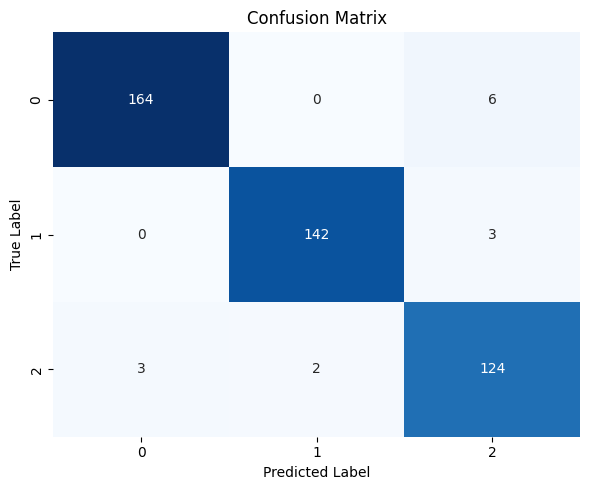

In [ ]:
conf_matrix(y_test, y_pred, labels=sorted(set(y_test)))